In [6]:
!pip install ipywidgets


Defaulting to user installation because normal site-packages is not writeable


In [10]:
!pip install widgetsnbextension


Defaulting to user installation because normal site-packages is not writeable


In [14]:
!pip install jupyter_contrib_nbextensions

Defaulting to user installation because normal site-packages is not writeable


In [119]:
pip install ipywidgets


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install ipympl


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
%matplotlib widget

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
from ipywidgets import FileUpload, Output
from IPython.display import display
import ipympl  # For interactive plotting in Jupyter notebooks

# Enable interactive plotting
%matplotlib widget

# File upload widget for Jupyter/Colab
upload_widget = FileUpload(accept='image/*', multiple=False)
image_uploaded = False
image = None
clicked_points = []
output = Output()

# Function to load the uploaded image
def load_image(change):
    global image_uploaded, image
    if image_uploaded: return
    if upload_widget.value:
        uploaded_file = upload_widget.value[0]
        image_data = uploaded_file['content']
        np_image = np.frombuffer(image_data, np.uint8)
        image = cv2.imdecode(np_image, cv2.IMREAD_COLOR)
        image_uploaded = True
        upload_widget.disabled = True
        print("Image uploaded successfully.")
        display_image_with_grid()

# Adjusted Mouse click event handler
def onclick(event, ax, cid, fig):
    global clicked_points
    x, y = event.xdata, event.ydata
    if x is None or y is None:
        # Redirect output to the Output widget
        with output:
            print("Click outside the valid region detected. Ignored.")
        return  # Ignore clicks outside the image region
    clicked_points.append((x, y))
    with output:  # Print to the Output widget
        print(f"Clicked: ({x:.2f}, {y:.2f})")  # Log the clicked coordinates
    ax.scatter(x, y, color='red')  # Mark the point on the image
    ax.text(x, y, f'({x:.2f}, {y:.2f})', color='red')
    plt.draw()

    if len(clicked_points) == 5:
        # Duplicate the third point to act as both the last of the top curve and the first of the bottom curve
        clicked_points.insert(3, clicked_points[2])
        with output:  # Print to the Output widget
            print("Five points clicked. Processing Cobb Angle...")
        fig.canvas.mpl_disconnect(cid)  # Disconnect the event listener
        process_cobb_angle()


def process_cobb_angle():
    global clicked_points
    if len(clicked_points) < 6:  # Since we now expect 6 points due to duplication
        with output:
            print("Not enough points to calculate Cobb angle.")
        return

    # Split clicked points into two groups for two curves
    top_points = clicked_points[:3]
    bottom_points = clicked_points[3:]

    # Calculate Cobb angles for top and bottom curves
    top_cobb_angle = calculate_cobb_angle(top_points)
    bottom_cobb_angle = calculate_cobb_angle(bottom_points)

    # Determine maximum Cobb angle and corresponding points
    if top_cobb_angle > bottom_cobb_angle:
        max_cobb_angle = top_cobb_angle
        max_points = top_points
    else:
        max_cobb_angle = bottom_cobb_angle
        max_points = bottom_points

    # Determine curve type
    if top_cobb_angle >= 15 and bottom_cobb_angle >= 15:
        curve_type = "S-shaped curve"
    elif top_cobb_angle >= 15 or bottom_cobb_angle >= 15:
        curve_type = "C-shaped curve"
    else:
        curve_type = "No significant curve detected"

    # Determine severity
    if 15 < max_cobb_angle < 20:
        severity = (
            "Mild scoliosis: Cobb angle of 10–20 degrees. \n"
            "Usually observed without treatment, and exercise treatment may be recommended.\n"
        )
    elif 20 <= max_cobb_angle <= 40:
        severity = (
            "Moderate scoliosis: Cobb angle of 20–40 degrees. \n"
            "Bracing may be required to stop the curve from progressing.\n"
        )
    else:
        severity = (
            "Severe scoliosis: Cobb angle of more than 40 degrees. \n"
            "Spinal fusion surgery may be required to correct the curve.\n"
        )

    # Display results
    with output:
        print(f"Top Cobb Angle: {top_cobb_angle:.2f}°")
        print(f"Bottom Cobb Angle: {bottom_cobb_angle:.2f}°")
        print(f"Maximum Cobb Angle: {max_cobb_angle:.2f}°")
        print(f"Curve Type: {curve_type}")
        print(f"Severity: \n{severity}")

    # Display the image with highlights
    display_results_with_highlights(max_points, max_cobb_angle, image)


# Calculate the Cobb angle using three points
def calculate_cobb_angle(points):
    # Get the coordinates of the three points
    x1, y1 = points[0]
    x2, y2 = points[1]
    x3, y3 = points[2]

    # Calculate the slopes of the two lines
    m1 = (y2 - y1) / (x2 - x1) if x2 != x1 else float('inf')
    m2 = (y3 - y2) / (x3 - x2) if x3 != x2 else float('inf')

    # Calculate the angle between the two lines in radians
    if m1 == float('inf') or m2 == float('inf'):
        angle_rad = np.pi / 2  # 90 degrees if one line is vertical
    else:
        angle_rad = abs(np.arctan((m2 - m1) / (1 + m1 * m2)))
    
    # Convert angle to degrees
    angle_deg = np.degrees(angle_rad)
    return angle_deg


# Function to display the image with grid and corrected y-axis labels
def display_image_with_grid():
    global image, clicked_points
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with output:
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(image_rgb)
        ax.set_xlim(0, image_rgb.shape[1])
        ax.set_ylim(0, image_rgb.shape[0])  # Set the y-axis from bottom to top, keeping the image intact
        plt.title("Click on 5 vertebrae points")

        # Invert the y-axis labels without flipping the image
        ax.invert_yaxis()  # Inverts only the y-axis labels, not the image itself

        # Bind click event with onclick and pass the cid and fig
        print("Binding click event to figure...")
        cid = fig.canvas.mpl_connect('button_press_event', lambda event: onclick(event, ax, cid, fig))
        print(f"Event connected with ID: {cid}")

        plt.show()

def display_results_with_highlights(points, max_cobb_angle, image):
    global clicked_points
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(image_rgb)
    ax.set_xlim(0, image_rgb.shape[1])
    ax.set_ylim(image_rgb.shape[0], 0)


# Display upload widget and image output widget
display(upload_widget, output)
upload_widget.observe(load_image, names='value')

FileUpload(value=(), accept='image/*', description='Upload')

Output()

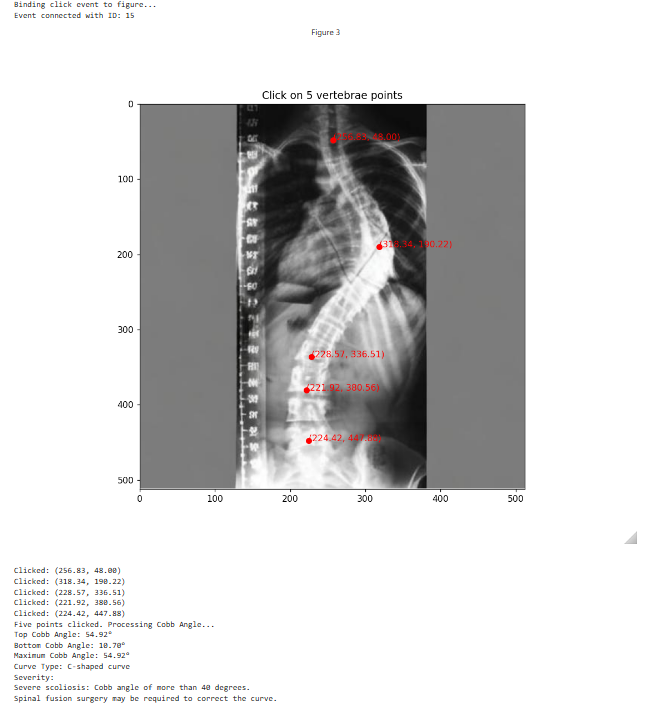

In [ ]:
""""
Screenshot of Output
Since the output cannot be directly visualized after download, the result is shown below as a screenshot for better understanding.
"""

from IPython.display import Image, display

# Display a local image file
display(Image(filename='ss.png'))
